In [2]:
#linhongbojob@163.com guangdong china
#coding:utf-8
from rdkit import Chem,DataStructs
from rdkit.Chem import Draw
from rdkit.Chem import MACCSkeys
from rdkit import DataStructs
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem.PandasTools import LoadSDF
import numpy as np
from keras import layers
from keras.layers import Input,Dense,Activation,Dropout
from keras.models import Sequential
from keras.models import load_model
import pandas as pd
from numpy.linalg import *
from sklearn import metrics
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  
import pickle
import cirpy
import pubchempy as pcp

In [3]:
#convert smiles to maccs fingerprint
def smilestomaccs(smile):
    mol = Chem.MolFromSmiles(smile)
    fps=MACCSkeys.GenMACCSKeys(mol)
    fp_arr=np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fps,fp_arr)
    return np.array(fp_arr)


In [4]:
#read file. 50 lines for manual testing. shuffled was done before
def readdata(xlsx_data):
    df_raw=pd.read_excel(xlsx_data)
    print('rawdata：',df_raw.shape)
    train_data=df_raw.iloc[50:,3553:]
    print("traindata：",train_data.shape)
    y_data=df_raw.iloc[50:,201:3552]
    print("targetdata：",y_data.shape)
    test_x=df_raw.iloc[:50,3553:]
    test_y=df_raw.iloc[:50,201:3552]
    return np.array(train_data),np.array(y_data),np.array(test_x),np.array(test_y)

In [5]:
#normalize
def nor(rawdata):
    r=rawdata*0.01
    r_r=np.round(r,1)
    return r_r

In [28]:
#model
def spectratomaccs(matrix_a,matrix_b,steps,logfile,modelfile):
    model=Sequential()
    model.add(Dense(matrix_b.shape[1],input_dim=matrix_a.shape[1],activation='relu'))
    model.add(Dense(3500,activation='relu'))
    model.add(Dropout(0.6))
    model.add(Dense(2500,activation='relu'))
    model.add(Dropout(0.6))
    model.add(Dense(1000,activation='relu'))
    model.add(Dropout(0.6))
    model.add(Dense(matrix_b.shape[1],activation='sigmoid'))
    model.summary(
    model.compile(optimizer='Adam',loss='binary_crossentropy' ,metrics=['binary_accuracy']))
    history=model.fit(matrix_a,matrix_b,epochs=steps,batch_size=128, validation_split=0.2)
    model.save(modelfile+'.h5')#
    filename=logfile+'.txt'
    with open (filename,'wb+') as file:
        pickle.dump(history,file)
    plt.plot(range(steps),history.history['loss'])
    plt.plot(range(steps),history.history['binary_accuracy'])
    plt.show()
    return 'finished！'

In [7]:
#generate maccs from ir spectra using existed model
def cal_spectra_m2s(key,m_r):
    model = load_model(m_r)
    try:
        key=key.reshape(1,-1)
        yt=model.predict(key)[0]
    except:
        yt=model.predict(key)[0]         
    return yt

In [8]:
Y,X,TY,TX=readdata('0313.xlsx')

rawdata： (11610, 3719)
traindata： (11560, 166)
targetdata： (11560, 3351)


In [10]:
X1=nor(X) 

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 166)               556432    
                                                                 
 dense_29 (Dense)            (None, 3500)              584500    
                                                                 
 dropout_15 (Dropout)        (None, 3500)              0         
                                                                 
 dense_30 (Dense)            (None, 2500)              8752500   
                                                                 
 dropout_16 (Dropout)        (None, 2500)              0         
                                                                 
 dense_31 (Dense)            (None, 1000)              2501000   
                                                                 
 dropout_17 (Dropout)        (None, 1000)             

73/73 [==============================] - 6s 78ms/step - loss: 0.1356 - binary_accuracy: 0.9454 - val_loss: 0.1960 - val_binary_accuracy: 0.9262
Epoch 45/50
73/73 [==============================] - 6s 78ms/step - loss: 0.1334 - binary_accuracy: 0.9460 - val_loss: 0.1916 - val_binary_accuracy: 0.9275
Epoch 46/50
73/73 [==============================] - 6s 79ms/step - loss: 0.1332 - binary_accuracy: 0.9462 - val_loss: 0.1898 - val_binary_accuracy: 0.9275
Epoch 47/50
73/73 [==============================] - 6s 78ms/step - loss: 0.1312 - binary_accuracy: 0.9470 - val_loss: 0.1896 - val_binary_accuracy: 0.9281
Epoch 48/50
73/73 [==============================] - 6s 78ms/step - loss: 0.1302 - binary_accuracy: 0.9478 - val_loss: 0.1914 - val_binary_accuracy: 0.9278
Epoch 49/50
73/73 [==============================] - 6s 79ms/step - loss: 0.1308 - binary_accuracy: 0.9474 - val_loss: 0.1915 - val_binary_accuracy: 0.9279
Epoch 50/50
73/73 [==============================] - 6s 77ms/step - loss: 0.

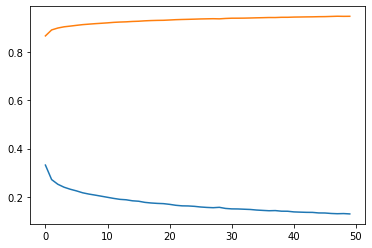

'finished！'

In [29]:
spectratomaccs(X1,Y,50,'GENMACCS','GENMACCS')

In [30]:
#test using jacarrd
print('NO.','similarity')
for i in range(0,50):
    sub=np.intersect1d(np.where(TY[i]==1)[0], np.where(cal_spectra_m2s(TX[i],'GENMACCS.h5')==1)[0])
    union=np.union1d(np.where(TY[i]==1)[0], np.where(cal_spectra_m2s(TX[i],'GENMACCS.h5')==1)[0])
    print(str(i),'  %.2f' %(len(sub)/len(union)))

        


NO. similarity
0   0.46
1   0.29
2   0.31
3   0.55
4   0.75
5   0.07
6   0.56
7   0.21
8   0.89
9   0.21
10   0.18
11   0.62
12   0.10
13   0.07
14   0.50
15   0.35
16   0.75
17   0.43
18   0.89
19   0.24
20   0.83
21   0.80
22   0.88
23   0.18
24   0.70
25   0.33
26   0.91
27   0.86
28   0.53
29   1.00
30   1.00
31   0.78
32   0.98
33   0.70
34   0.21
35   0.97
36   0.16
37   0.36
38   0.62
39   0.71
40   0.90
41   0.09
42   0.69
43   0.70
44   0.69
45   0.55
46   0.96
47   0.56
48   0.46
49   0.56


#TEST DATA CAS:
7209-00-9
2045-70-7
121-60-8
1592-23-0
629-41-4
376-27-2
142-82-5
91-59-8
80-08-0
41663-73-4
115-96-8
131-54-4
101-77-9
1877-73-2
10318-18-0
106-20-7
115-77-5
109-66-0
120-46-7
4845-58-3
2295-31-0
101-90-6
2041-19-2
56-89-3
123-08-0
114-07-8
1163-19-5
3287-99-8
87-51-4
1333-88-6
58-32-2
5988-19-2
506-30-9
7722-76-1
68-35-9
132-18-3
95-24-9
2305-36-4
87-87-6
504-63-2
637-12-7
67-51-6
66-22-8
2708-97-6
128-09-6
1603-41-4
102-71-6
2623-33-8
2503-56-2
87-44-5
